In [1]:
import pandas
import numpy as np
import os
import re
import random
import nltk
from collections import Counter

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt
from statistics import mean
from statistics import median
from statistics import stdev

In [2]:
# Reading index data
index_df = pandas.read_csv('billboard-2.0-index.csv')
index_df = index_df.dropna()
index_df

# Note not all index in use - those without associated chord sheets not included

,id,chart_date,target_rank,actual_rank,title,artist,peak_rank,weeks_on_chart
2,3,1961-07-03,56,57.0,I Don't Mind,James Brown,47.0,8.0
3,4,1971-08-07,32,31.0,You've Got A Friend,"Roberta Flack,Donny Hathaway",29.0,12.0
5,6,1980-08-02,15,16.0,The Rose,Bette Midler,3.0,25.0
9,10,1984-03-24,49,51.0,An Innocent Man,Billy Joel,10.0,18.0
11,12,1980-11-15,65,63.0,Lookin' For Love,Johnny Lee,5.0,21.0
...,...,...,...,...,...,...,...,...
1289,1290,1967-04-22,2,2.0,Happy Together,The Turtles,1.0,15.0
1291,1292,1963-03-09,17,19.0,He's So Fine,The Chiffons,1.0,15.0
1295,1296,1983-07-02,34,36.0,White Wedding,Billy Idol,36.0,13.0
1296,1297,1961-03-13,7,9.0,Ebony Eyes,The Everly Brothers,8.0,12.0


In [3]:
# Reading music data and extracting raw data

rootdir = 'C://Users//lasse//Desktop//FREE TOPIC//Code//McGill-Billboard//'

raw_song_data = []
complete_chord_set = []

count = 0
for folder in os.listdir(rootdir):
    with open(rootdir + folder + '//salami_chords.txt') as f:
        
        song_dict = {}
        title = ""
        artist = ""
        metre = []
        tonic = []
        choords_phrases = []
        choords = []
        length = ""
        phrases = 0
        
        for i, line in enumerate(f):
            
            if "# title" in line:
                title = line.replace("# title: ", "")
                title = title.replace("\n", "")
            if "# artist" in line:
                artist = line.replace("# artist: ", "")
                artist = artist.replace("\n", "")
                artist = artist.lower()
            if "# metre" in line:
                metre_raw = line.replace("# metre: ", "")
                metre.append(metre_raw.replace("\n", ""))
            if "# tonic" in line:
                tonic_raw = line.replace("# tonic: ", "")
                tonic.append(tonic_raw.replace("\n", ""))
            if "|" in line:
                phrases += 1
                ch = '|'
                split_line1 = line.split(ch, 1)
                split_line2 = split_line1[1].rsplit(ch, 1)
                
                split_chords = split_line2[0].split()
                for item in split_chords:
                    if item != "|" and item != "." and item != "..":
                        choords.append(item)
                        complete_chord_set.append(item)
                
                choords_phrases.append(split_line2[0])
                
        length = line.replace("end", "")
        length = float(length.strip())
        
        index = count
        count += 1

        
        song_dict = {
            "title": title,
            "artist": artist,
            "metre": metre,
            "tonic": tonic,
            "choords_phrases": choords_phrases,
            "choords": choords,
            "length": length,
            "phrases": phrases,
            "index": index
        }
        raw_song_data.append(song_dict)

In [4]:
raw_song_data[0]

{'title': "I Don't mind",
 'artist': 'james brown',
 'metre': ['6/8'],
 'tonic': ['C'],
 'choords_phrases': [' A:min | A:min | C:maj | C:maj ',
  ' A:min | A:min | C:maj | C:maj ',
  ' A:min | A:min | C:maj | C:maj ',
  ' A:min | A:min | C:maj | C:maj ',
  ' A:min | A:min | C:maj | C:maj ',
  ' F:maj | F:maj | D:maj | D:maj ',
  ' G:maj | G:maj | C:maj | C:maj ',
  ' A:maj | A:maj | C:maj | C:maj ',
  ' A:maj | A:maj | C:maj | C:maj ',
  ' F:maj | F:maj | D:maj | D:maj ',
  ' G:maj | G:maj | C:maj | C:maj ',
  ' A:min | A:min | C:maj | C:maj ',
  ' A:min | A:min | C:maj | C:maj ',
  ' F:maj | F:maj | D:maj | D:maj ',
  ' G:maj | G:maj | C:maj | C:maj ',
  ' A:maj | A:maj | C:maj | C:maj ',
  ' A:maj | A:maj | C:maj | C:maj ',
  ' F:maj | F:maj | D:maj | D:maj ',
  ' G:maj | G:maj | C:maj | C:maj ',
  ' A:min | A:min | C:maj | C:maj ',
  ' A:min | A:min | C:maj | C:maj ',
  ' A:min '],
 'choords': ['A:min',
  'A:min',
  'C:maj',
  'C:maj',
  'A:min',
  'A:min',
  'C:maj',
  'C:maj',
  '

In [5]:
# TEMPORARY SOLUTION! Glitch in last entry
del raw_song_data[-1]

### Feature extraction

In [26]:
# Creating chord n-grams

chord2grams = list(nltk.ngrams(complete_chord_set, 2))
chord2grams_counter = Counter(chord2grams)
most_common_2grams = chord2grams_counter.most_common(50)

chord3grams = list(nltk.ngrams(complete_chord_set, 3))
chord3grams_counter = Counter(chord3grams)
most_common_3grams = chord3grams_counter.most_common(50)

chord4grams = list(nltk.ngrams(complete_chord_set, 4))
chord4grams_counter = Counter(chord4grams)
most_common_4grams = chord4grams_counter.most_common(50)

most_common_2grams = [char[0] for char in most_common_2grams]
most_common_3grams = [char[0] for char in most_common_3grams]
most_common_4grams = [char[0] for char in most_common_4grams]

In [7]:
# Feature extraction for each song

all_features = []

for i, song in enumerate(raw_song_data):
    
    # Author
    artist = song["artist"]
    
    # length
    length_of_song = song["length"]
    
    # phrases
    no_of_phrases = song["phrases"]
    
    # metre
    if len(song["metre"]) > 0:
        for item in song["metre"]:
            metre += item
        else:
            metre = item
    metre_changes = len(song["metre"])
    
    # tonic
    if len(song["tonic"]) > 0:
        for item in song["tonic"]:
            tonic += item
        else:
            tonic = item
    tonic_changes = len(song["tonic"])
    
    # Choords
    most_common_chord = max(set(song["choords"]), key = song["choords"].count)
    no_of_unique_chords = len(set(song["choords"]))
    
    # Complexity
    longest_chordname = 0
    shortest_chordname = 99
    chord_complexity = []
    
    for chord_name in song["choords"]:
        if len(chord_name) > longest_chordname:
            longest_chordname = len(chord_name)
        if len(chord_name) < shortest_chordname:
            shortest_chordname = len(chord_name)
        chord_complexity.append(len(chord_name))
        
    mean_complexity = mean(chord_complexity)
    median_complexity = median(chord_complexity)
    std_complexity = stdev(chord_complexity)
    
    # Chord 2grams
    twogram_count = []
    song_2_grams = list(nltk.ngrams(song["choords"], 2))
    
    for gram in most_common_2grams:
        if song_2_grams.count(gram) > 0:
            twogram_count.append(song_2_grams.count(gram))
        elif song_2_grams.count(gram) == 0:
            twogram_count.append(0)
            
    # Chord 3grams
    threegram_count = []
    song_3_grams = list(nltk.ngrams(song["choords"], 3))
    
    for gram in most_common_3grams:
        if song_3_grams.count(gram) > 0:
            threegram_count.append(song_3_grams.count(gram))
        elif song_3_grams.count(gram) == 0:
            threegram_count.append(0)
            
    # Chord 4grams
    fourgram_count = []
    song_4_grams = list(nltk.ngrams(song["choords"], 4))
    
    for gram in most_common_4grams:
        if song_4_grams.count(gram) > 0:
            fourgram_count.append(song_4_grams.count(gram))
        elif song_4_grams.count(gram) == 0:
            fourgram_count.append(0)
        
    
    temp_feature_list = []
    
    temp_feature_list.append(artist)
    temp_feature_list.append(length_of_song)
    temp_feature_list.append(no_of_phrases)
    temp_feature_list.append(metre)
    temp_feature_list.append(metre_changes)
    temp_feature_list.append(tonic)
    temp_feature_list.append(tonic_changes)
    temp_feature_list.append(most_common_chord)
    temp_feature_list.append(no_of_unique_chords)
    temp_feature_list.append(longest_chordname)
    temp_feature_list.append(shortest_chordname)
    temp_feature_list.append(mean_complexity)
    temp_feature_list.append(median_complexity)
    temp_feature_list.append(std_complexity)
    
    for item in twogram_count:
        temp_feature_list.append(item)
    for item in threegram_count:
        temp_feature_list.append(item)
    for item in fourgram_count:
        temp_feature_list.append(item)
    
    all_features.append(temp_feature_list)
    
    if i % 100 == 0:
        print(f"{i} of {len(raw_song_data)}")
print("Done!")

0 of 889
100 of 889
200 of 889
300 of 889
400 of 889
500 of 889
600 of 889
700 of 889
800 of 889
Done!


### Dataset creation

In [8]:
# Looking at number of unique artists before matching up
artists = []
for song in all_features:
    artists.append(song[0])

print(f"No. of songs: {len(artists)} - No. of unique artists: {len(set(artists))}")

No. of songs: 889 - No. of unique artists: 448


In [9]:
# Most featured artists
artists.sort()
print(sorted(artists, key=Counter(artists).get, reverse=True))

['elvis presley', 'elvis presley', 'elvis presley', 'elvis presley', 'elvis presley', 'elvis presley', 'elvis presley', 'elvis presley', 'elvis presley', 'elvis presley', 'elvis presley', 'elvis presley', 'elvis presley', 'elvis presley', 'elvis presley', 'elvis presley', 'elvis presley', 'elvis presley', 'elvis presley', 'brenda lee', 'brenda lee', 'brenda lee', 'brenda lee', 'brenda lee', 'brenda lee', 'brenda lee', 'brenda lee', 'brenda lee', 'brenda lee', 'chicago', 'chicago', 'chicago', 'chicago', 'chicago', 'chicago', 'chicago', 'chicago', 'chicago', 'chicago', 'dion', 'dion', 'dion', 'dion', 'dion', 'dion', 'dion', 'dion', 'dion', 'dion', 'rolling stones', 'rolling stones', 'rolling stones', 'rolling stones', 'rolling stones', 'rolling stones', 'rolling stones', 'rolling stones', 'rolling stones', 'cyndi lauper', 'cyndi lauper', 'cyndi lauper', 'cyndi lauper', 'cyndi lauper', 'cyndi lauper', 'cyndi lauper', 'cyndi lauper', 'james brown', 'james brown', 'james brown', 'james brow

In [10]:
# Song length and average number of chords
lengths_count = []
number_of_chords_count = []

for item in raw_song_data:
    lengths_count.append(item["length"])
    number_of_chords_count.append(len(item["choords"]))

print(mean(lengths_count))
print(mean(number_of_chords_count))

216.27120977178177
128.7154105736783


In [11]:
songs_A = raw_song_data.copy()
songs_B = raw_song_data.copy()

In [12]:
# Mix songs so some are by same author

list_of_song_pairs = []

for i, song in enumerate(songs_A):
    match_found = False
    for j, pot_match in enumerate(songs_B):
        if song["artist"] == pot_match["artist"] and i != j and match_found != True and song["title"] != pot_match["title"]:
            # print(pot_match["artist"], i, j)
            list_of_song_pairs.append([raw_song_data[song["index"]], raw_song_data[pot_match["index"]]])
            match_found = True
            del songs_B[j]
            break
    if match_found == False:
        indeces = list(range(len(songs_B)))
        rand_choice = random.choice(indeces)
        rand_song = songs_B[rand_choice]
        list_of_song_pairs.append([raw_song_data[song["index"]], raw_song_data[rand_song["index"]]])
        del songs_B[rand_choice]

In [13]:
songs_A[1]

{'title': "You've got a Friend",
 'artist': 'roberta flack and donny hathaway',
 'metre': ['4/4'],
 'tonic': ['Ab'],
 'choords_phrases': [' Ab:maj | Db:maj/5 | Ab:maj | G:hdim7 C:7 ',
  ' F:min | C:7/5 C:7 | F:min C:7/5 | F:min/b3 C:7/5 F:min . ',
  ' Bb:min7 | Eb:7 | Ab:maj | Ab:maj ',
  ' G:hdim7 | C:7 | F:min C:7/5 | F:min/b3 C:7/5 F:min . ',
  ' Bb:min7 | C:min7 | Eb:11 | Eb:maj ',
  ' Ab:maj | Ab:7 | Db:maj | Db:maj ',
  ' Ab:maj | Ab:maj | Eb:7 | Eb:7 ',
  ' Ab:maj | Ab:maj7 | Db:maj | Gb:maj Db:maj . . ',
  ' Db:maj7 C:min7 | Bb:min7 | Ab:maj ',
  ' Gb:maj(9) | Db:maj | Ab:maj | Ab:maj ',
  ' Db:maj | Gb:7 | F:min7 | Bb:min7 | Eb:11 | Eb:maj ',
  ' Ab:maj | Ab:7 | Db:maj | Db:maj ',
  ' Ab:maj | Ab:maj | Eb:7 | Eb:7 ',
  ' Ab:maj | Ab:maj7 | Db:maj | Gb:maj Db:maj . . ',
  ' Db:maj7 C:min7 | Bb:min7 ',
  ' Ab:maj | Db:maj/5 ',
  ' Ab:maj | Db:maj/5 ',
  ' Ab:maj | Db:maj/5 ',
  ' Ab:maj | Db:maj/5 ',
  ' Ab:maj | Db:maj/5 ',
  ' Ab:maj | Db:maj/5 '],
 'choords': ['Ab:maj',
  'Db

In [14]:
# Check stats and create Y values

same = 0
notsame = 0

y = []

for duo in list_of_song_pairs:
    if duo[0]["artist"] == duo[1]["artist"]:
        same += 1
        y.append(1)
    else:
        notsame += 1
        y.append(0)
        
print(f"{same}/{same+notsame} pairs of same author and {notsame}/{same+notsame} pairs of different author")

321/889 pairs of same author and 568/889 pairs of different author


### Pair-wise feature comparison

In [15]:
X = []

for pair in list_of_song_pairs:
    
    len_diff = 0
    no_phrases_diff = 0
    same_meter = 0
    meter_changes_diff = 0
    same_tonic = 0
    tonic_changes_diff = 0
    same_most_common_chord = 0
    diff_no_unique_chords = 0
    diff_longest_chordname = 0
    diff_shortest_chordname = 0
    diff_mean_complex = 0
    diff_median_complex = 0
    diff_stdev_complex = 0
    
    pair_features = []
    
    f_list_a = all_features[pair[0]["index"]]
    f_list_b = all_features[pair[1]["index"]]
    
    # Difference in length
    len_diff = abs(f_list_a[1] - f_list_b[1])
    
    # Differene in no. of phrases
    no_phrases_diff = abs(f_list_a[2] - f_list_b[2])
    
    # Same meter?
    if f_list_a[3] == f_list_b[3]:
        same_meter = 1
    else:
        same_meter = 0
        
    # Difference in number of meter-changes
    meter_changes_diff = abs(f_list_a[4] - f_list_b[4])
    
    # Same tonic?
    if f_list_a[5] == f_list_b[5]:
        same_tonic = 1
    else:
        same_tonic = 0
    
    # Difference in number of tonic changes
    tonic_changes_diff = abs(f_list_a[6] - f_list_b[6])
    
    # Same most common chord?
    if f_list_a[7] == f_list_b[7]:
        same_most_common_chord = 1
    else:
        same_most_common_chord = 0
    
    # Difference in number of unique chords
    diff_no_unique_chords = abs(f_list_a[8] - f_list_b[8])
    
    # Difference in complexity
    diff_longest_chordname = abs(f_list_a[9] - f_list_b[9])
    diff_shortest_chordname = abs(f_list_a[10] - f_list_b[10])
    diff_mean_complex = abs(f_list_a[11] - f_list_b[11])
    diff_median_complex = abs(f_list_a[12] - f_list_b[12])
    diff_stdev_complex = abs(f_list_a[13] - f_list_b[13])
    
    
    # Similarity metrics
    pair_features.append(len_diff)
    pair_features.append(same_meter)
    pair_features.append(same_tonic)
    pair_features.append(same_most_common_chord)
    
    # Structural complexity
    pair_features.append(no_phrases_diff)
    pair_features.append(meter_changes_diff)
    pair_features.append(tonic_changes_diff)
    
    # Chord complexity
    pair_features.append(diff_no_unique_chords)
    pair_features.append(diff_longest_chordname)
    pair_features.append(diff_shortest_chordname)
    pair_features.append(diff_mean_complex)
    pair_features.append(diff_median_complex)
    pair_features.append(diff_stdev_complex)

    # Difference in n-gram distribution
    for i in range(14, len(f_list_a)):
        pair_features.append(abs(f_list_a[i] - f_list_b[i])) 
    
    X.append(pair_features)

### Grid param search

In [16]:
X = np.array(X)
y = np.array(y)

### Validation

In [17]:
X = np.array(X)
y = np.array(y)

Avg accuracy : 0.6392369707357328
Avg f1 : 0.0
Avg recall : 0.0
Avg precision : 0.0


C:\Users\lasse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lasse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lasse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lasse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being se

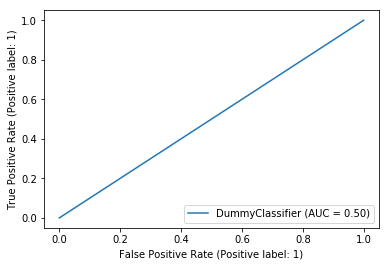

In [18]:
# DUMMY

k = 5
kf = KFold(n_splits = k, random_state = None)
model = DummyClassifier(strategy="most_frequent")

acc_score_list = []
f1_score_list = []
recall_score_list = []
precision_score_list = []
 
for train_index , test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values, y_test)
    f1 = f1_score(pred_values, y_test)
    recall = recall_score(pred_values, y_test)
    precision = precision_score(pred_values, y_test)
    
    acc_score_list.append(acc)
    f1_score_list.append(f1)
    recall_score_list.append(recall)
    precision_score_list.append(precision)
    
dummy_disp = plot_roc_curve(model, X_test, y_test)
     
avg_acc_score = sum(acc_score_list)/k
avg_f1_score = sum(f1_score_list)/k
avg_recall_score = sum(recall_score_list)/k
avg_precision_score = sum(precision_score_list)/k
 
print(f'Avg accuracy : {avg_acc_score}')
print(f'Avg f1 : {avg_f1_score}')
print(f'Avg recall : {avg_recall_score}')
print(f'Avg precision : {avg_precision_score}')

Avg accuracy : 0.606360693201295
Avg f1 : 0.3827718093267913
Avg recall : 0.4613447278805065
Avg precision : 0.4015086185537621


C:\Users\lasse\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


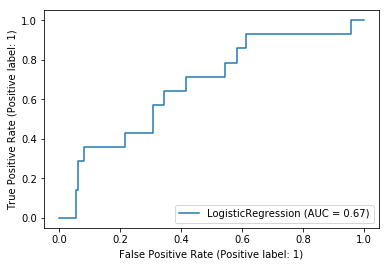

In [19]:
# LOGISTIC REGRESSION

k = 5
kf = KFold(n_splits = k, random_state = None)
model = LogisticRegression(solver= 'liblinear', penalty='l2', fit_intercept=True, dual=False, C=0.23357214690901212)

acc_score_list = []
f1_score_list = []
recall_score_list = []
precision_score_list = []
 
for train_index , test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values, y_test)
    f1 = f1_score(pred_values, y_test)
    recall = recall_score(pred_values, y_test)
    precision = precision_score(pred_values, y_test)
    
    acc_score_list.append(acc)
    f1_score_list.append(f1)
    recall_score_list.append(recall)
    precision_score_list.append(precision)
    
lr_disp = plot_roc_curve(model, X_test, y_test)
     
avg_acc_score = sum(acc_score_list)/k
avg_f1_score = sum(f1_score_list)/k
avg_recall_score = sum(recall_score_list)/k
avg_precision_score = sum(precision_score_list)/k
 
print(f'Avg accuracy : {avg_acc_score}')
print(f'Avg f1 : {avg_f1_score}')
print(f'Avg recall : {avg_recall_score}')
print(f'Avg precision : {avg_precision_score}')

Avg accuracy : 0.7729130959182379
Avg f1 : 0.5861169438275237
Avg recall : 0.7902824959771142
Avg precision : 0.5119096447961018


C:\Users\lasse\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


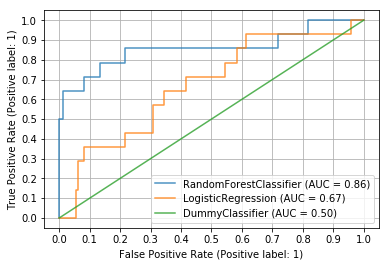

In [20]:
# RANDOM FOREST

k = 5
kf = KFold(n_splits = k, random_state = None)
model = RandomForestClassifier(
    n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features='log2',
    max_depth=50, criterion='entropy', bootstrap=True, random_state=0)

acc_score_list = []
f1_score_list = []
recall_score_list = []
precision_score_list = []
 
for train_index , test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values, y_test)
    f1 = f1_score(pred_values, y_test)
    recall = recall_score(pred_values, y_test)
    precision = precision_score(pred_values, y_test)
    
    acc_score_list.append(acc)
    f1_score_list.append(f1)
    recall_score_list.append(recall)
    precision_score_list.append(precision)
    
plt.grid()
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.yticks(np.arange(0.0, 1.1, step=0.1))
ax = plt.gca()
rf_disp = plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8)
lr_disp.plot(ax=ax, alpha=0.8)
dummy_disp.plot(ax=ax, alpha=0.8)
     
avg_acc_score = sum(acc_score_list)/k
avg_f1_score = sum(f1_score_list)/k
avg_recall_score = sum(recall_score_list)/k
avg_precision_score = sum(precision_score_list)/k
 
print(f'Avg accuracy : {avg_acc_score}')
print(f'Avg f1 : {avg_f1_score}')
print(f'Avg recall : {avg_recall_score}')
print(f'Avg precision : {avg_precision_score}')